# Compute behavioral similarity (via syllable usage) across individuals for different ages

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.distance import cdist, pdist, squareform
from toolz import partial
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, LONGTOGENY_AGE_CMAP

In [5]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "beh-individualization", tight_layout=False)

In [6]:
version = 7
folder = Path(f'/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}')

In [18]:
def load_long_df(version=5):
    usage_mtx = pd.read_parquet(
        f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longtogeny_males_clean.parquet"
    )
    return usage_mtx

In [60]:
df = pd.read_parquet(folder / "longtogeny_males_clean_pseudotime_v2.parquet")
df.set_index(['pseudo_age', 'pseudo_age_smooth'], append=True, inplace=True)

# df = load_long_df(version=5)
# df = df.query('age < 600')

keep_sylls = df.columns[df.median() > 0.005]
df = df[keep_sylls]

index = ['age', 'mouse', 'cage', 'uuid', 'subject_name', 'date', 'pseudo_age', 'pseudo_age_smooth']

In [61]:
index = ['binned_age'] + index
ages = df.index.get_level_values('pseudo_age_smooth')
lbls, bins = pd.qcut(ages, 15, labels=False, retbins=True)

df['binned_age'] = lbls
df = df.reset_index().set_index(index)
binned_ages = df.groupby(['binned_age', 'mouse', 'cage']).mean()

In [62]:
def shuffle_mouse_age(df):
    '''df parameter corresponds to all mice at a certain age/age bin'''
    df = df.reset_index()
    df['age'] = df.groupby('mouse')['age'].sample(frac=1).to_numpy()
    return df.set_index(index) 

In [63]:
shuff_dists = []
n_shuffs = 100
for i in range(n_shuffs):
    shuff_df = shuffle_mouse_age(df)
    dists = shuff_df.groupby('age').apply(partial(pdist, metric='jensenshannon'))
    dists.index = dists.index / 7
    avg_dist = dists.apply(lambda x: x.mean())
    avg_dist.name = i
    shuff_dists.append(avg_dist)
shuff_dists = pd.DataFrame(shuff_dists)
shuff_dists.index.name = 'shuffle'

In [64]:
shuff_df = shuff_dists.reset_index().melt(id_vars='shuffle', value_name='dist')

<Axes: xlabel='age', ylabel='dist'>

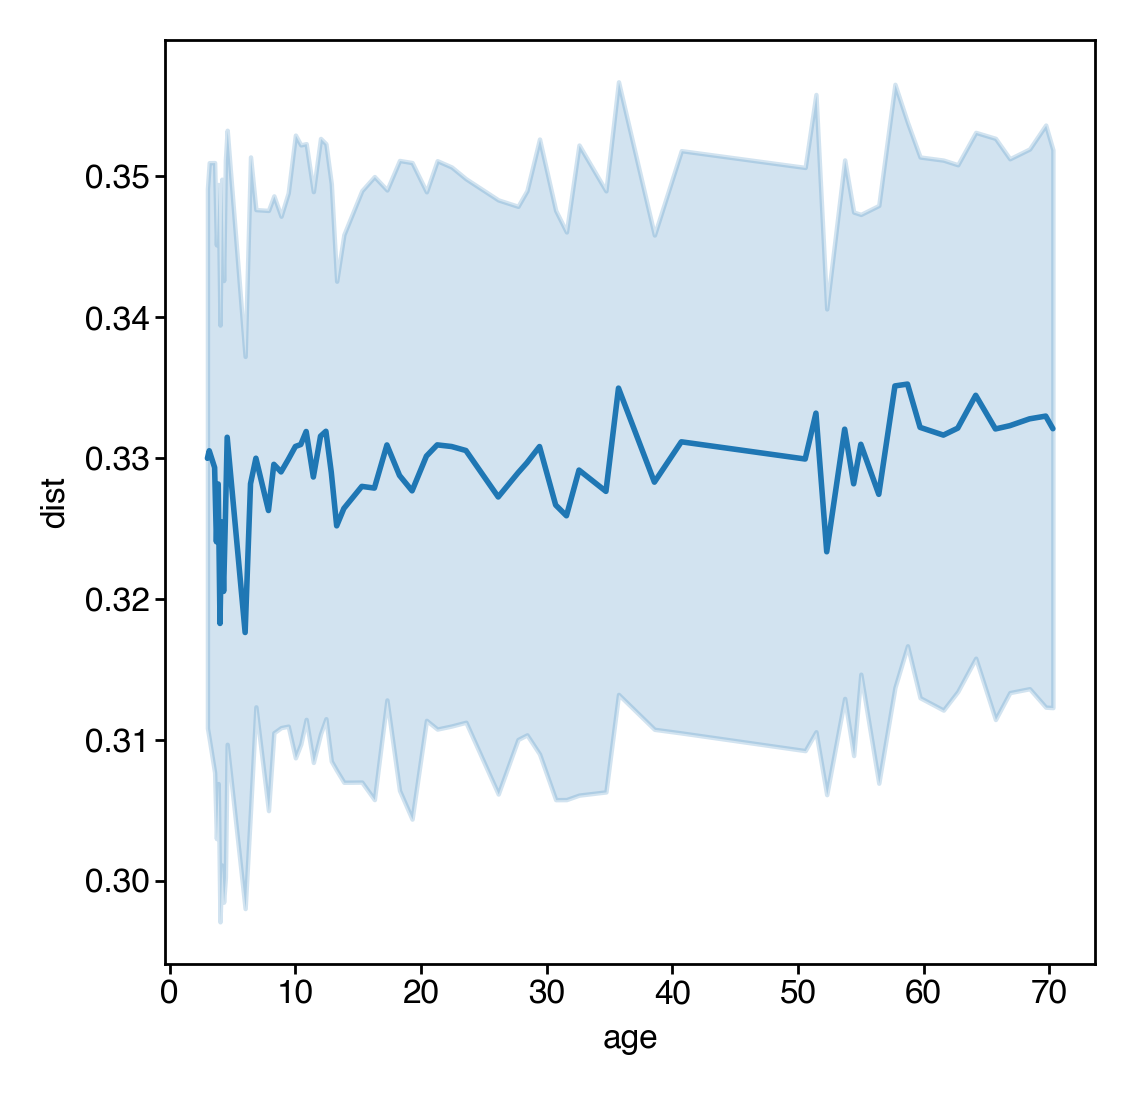

In [54]:
sns.lineplot(data=shuff_df, x='age', y='dist', errorbar='sd')

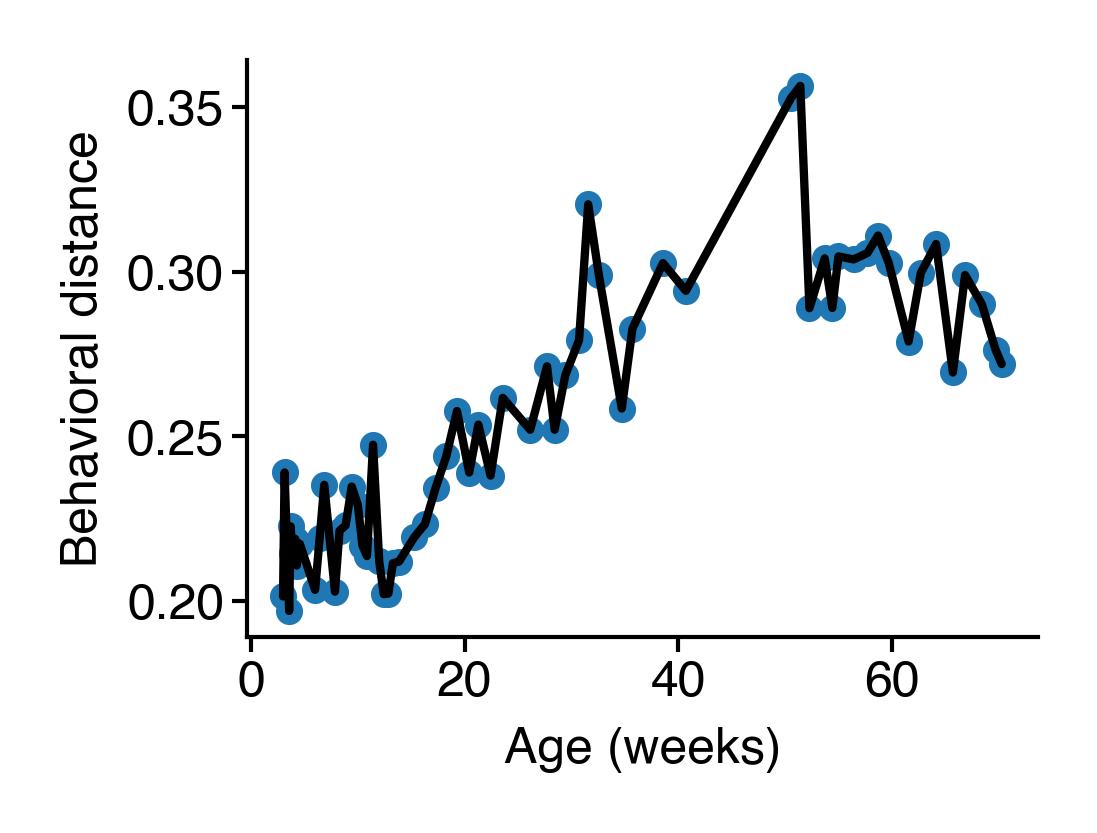

In [55]:
dists = df.groupby('age').apply(partial(pdist, metric='jensenshannon'))
dists.index = dists.index / 7
avg_dist = dists.apply(lambda x: x.mean())
avg_dist.name = 'dist'

fig = figure(1.7, 1.25)
ax = avg_dist.plot(c='k', lw=1)
ax = pd.DataFrame(avg_dist).reset_index().plot(kind='scatter', x='age', y='dist', ax=ax, s=6)
ax.set(xlabel="Age (weeks)", ylabel="Behavioral distance")
sns.despine()
# saver(fig, 'jsd-

In [ ]:
dists = df.groupby("age").apply(partial(pdist, metric="jensenshannon"))
dists.index = dists.index / 7
avg_dist = dists.apply(lambda x: x.mean())
avg_dist.name = "dist"

fig = figure(1.6, 1.25)
ax = fig.gca()
ax = avg_dist.plot(c="k", lw=1, zorder=-1, ax=ax)
ax = (
    pd.DataFrame(avg_dist)
    .reset_index()
    .plot(
        kind="scatter",
        x="age",
        y="dist",
        c="age",
        s=6,
        cmap=LONGTOGENY_AGE_CMAP,
        ax=ax,
    )
)
sns.lineplot(
    data=shuff_df,
    x="age",
    y="dist",
    errorbar=("sd", 2),
    color="gray",
    err_kws=dict(lw=0),
    ax=ax,
    label="Shuffle",
)
ax.set(xlabel="Pseudo age (weeks)", ylabel="Behavioral distance")
legend(ax)

sns.despine()
saver(fig, "age-vs-behavioral-distance");

In [56]:
def shuffle_binned_mouse_age(df):
    '''df parameter corresponds to all mice at a certain age/age bin'''
    df = df.reset_index()
    df['binned_age'] = df.groupby('mouse')['binned_age'].sample(frac=1, replace=True).to_numpy()
    return df.set_index(['binned_age', 'mouse', 'cage']) 

In [58]:
shuff_dists = []
n_shuffs = 1_000
for i in range(n_shuffs):
    shuff_df = shuffle_binned_mouse_age(binned_ages)
    dists = shuff_df.groupby("binned_age").apply(partial(pdist, metric="jensenshannon"))
    # dists.index = dists.index / 7
    avg_dist = dists.apply(lambda x: x.mean())
    avg_dist.name = i
    avg_dist.index = pd.Index(
        ((bins[:-1] + bins[1:]) / 2)[dists.index], name="binned_age"
    )
    shuff_dists.append(avg_dist)
shuff_dists = pd.DataFrame(shuff_dists)
shuff_dists.index.name = "shuffle"
shuff_df = shuff_dists.reset_index().melt(id_vars="shuffle", value_name="dist")

/tmp/ipykernel_14590/1172142516.py:7: RuntimeWarning: Mean of empty slice.
  avg_dist = dists.apply(lambda x: x.mean())
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_14590/1172142516.py:7: RuntimeWarning: Mean of empty slice.
  avg_dist = dists.apply(lambda x: x.mean())
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_14590/1172142516.py:7: RuntimeWarning: Mean of empty slice.
  avg_dist = dists.apply(lambda x: x.mean())
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_14590/1172142516.py:7: RuntimeWarning: Mean of empty slice.
  avg_d

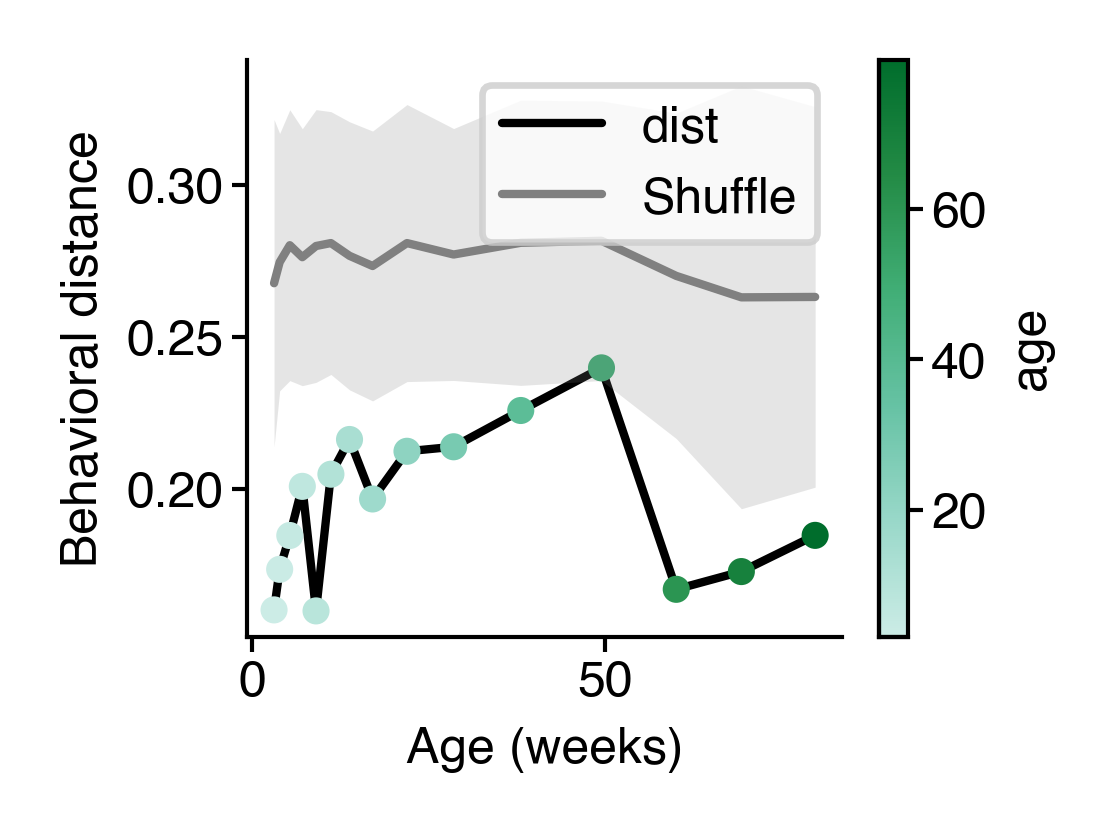

In [59]:
dists = binned_ages.groupby('binned_age').apply(partial(pdist, metric='jensenshannon'))
avg_dist = dists.apply(lambda x: x.mean())
avg_dist.name = 'dist'
avg_dist.index = pd.Index((bins[:-1] + bins[1:]) / 2, name='age')

fig = figure(1.6, 1.25)
ax = fig.gca()
ax = avg_dist.plot(c='k', lw=1, zorder=-1, ax=ax)
ax = pd.DataFrame(avg_dist).reset_index().plot(kind='scatter', x='age', y='dist', c='age', s=6, cmap=LONGTOGENY_AGE_CMAP, ax=ax)
sns.lineplot(data=shuff_df, x='binned_age', y='dist', errorbar=('sd', 2), color='gray', err_kws=dict(lw=0), ax=ax, label='Shuffle')
ax.set(xlabel="Age (weeks)", ylabel="Behavioral distance")
# legend(ax)

sns.despine()
# saver(fig, "age-vs-behavioral-distance-binned");

In [91]:
avg_dist.index

Index([3.3035714285714284, 3.9464285714285716,  5.357142857142857,
        7.642857142857143,  9.857142857142858, 11.642857142857142,
       13.857142857142858, 16.785714285714285, 20.357142857142858,
       25.428571428571427,               30.5, 36.642857142857146,
        47.30357142857143,  56.30357142857143, 62.214285714285715,
                     68.0],
      dtype='float64', name='age')

## examples of syllable usage between two animals at young vs old age

In [16]:
ba = df.groupby(['binned_age', 'mouse', 'cage']).mean()

In [17]:
ba.index.levels[1]

Index(['01_01', '01_02', '01_03', '01_04', '02_01', '02_02', '02_03', '02_04',
       '03_01', '03_02', '03_03', '03_04', '04_01', '04_02', '04_03', '04_04'],
      dtype='object', name='mouse')

In [94]:
b1 = ba.loc[2, "03_01"].to_numpy().squeeze()
b2 = ba.loc[2, "03_04"].to_numpy().squeeze()

b3 = ba.loc[13, "03_01"].to_numpy().squeeze()
b4 = ba.loc[13, "03_04"].to_numpy().squeeze()

syll_df = pd.concat(
    [
        pd.DataFrame(
            dict(
                diff=b1 - b2,
                sort_diff=np.sort(b1 - b2),
                m1=b1,
                m2=b2,
                age=int(avg_dist.index[2]),
                ord=np.arange(len(b1))[np.argsort(b1 - b2)],
            )
        ),
        pd.DataFrame(
            dict(
                diff=b3 - b4,
                sort_diff=np.sort(b3 - b4),
                m1=b3,
                m2=b4,
                age=int(avg_dist.index[13]),
                ord=np.arange(len(b3))[np.argsort(b3 - b4)],
            )
        ),
    ]
).reset_index()
syll_df = syll_df.rename(columns={"index": "syllable"})

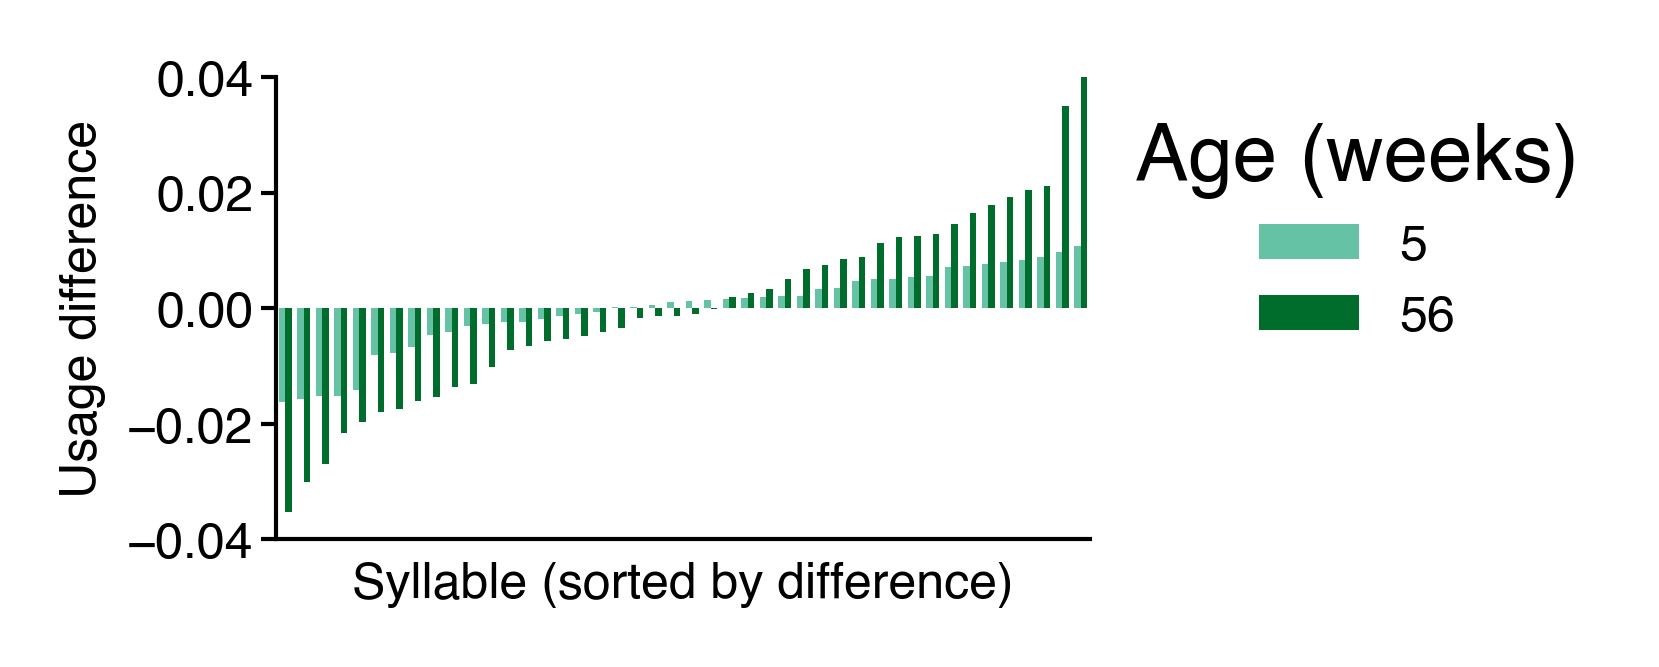

In [98]:
rs = LONGTOGENY_AGE_CMAP.resampled(6)
fig = figure(1.75, 1)
ax = sns.barplot(data=syll_df, x='syllable', y='sort_diff', hue='age', palette=rs([2, 5]).tolist(), width=0.7, saturation=1, lw=0)
ax.set(xticks=[], ylabel="Usage difference", ylim=[-0.04, 0.04], xlabel="Syllable (sorted by difference)")
sns.despine()
legend(ax, title="Age (weeks)")
saver(fig, "sorted-usage-difference-examples");

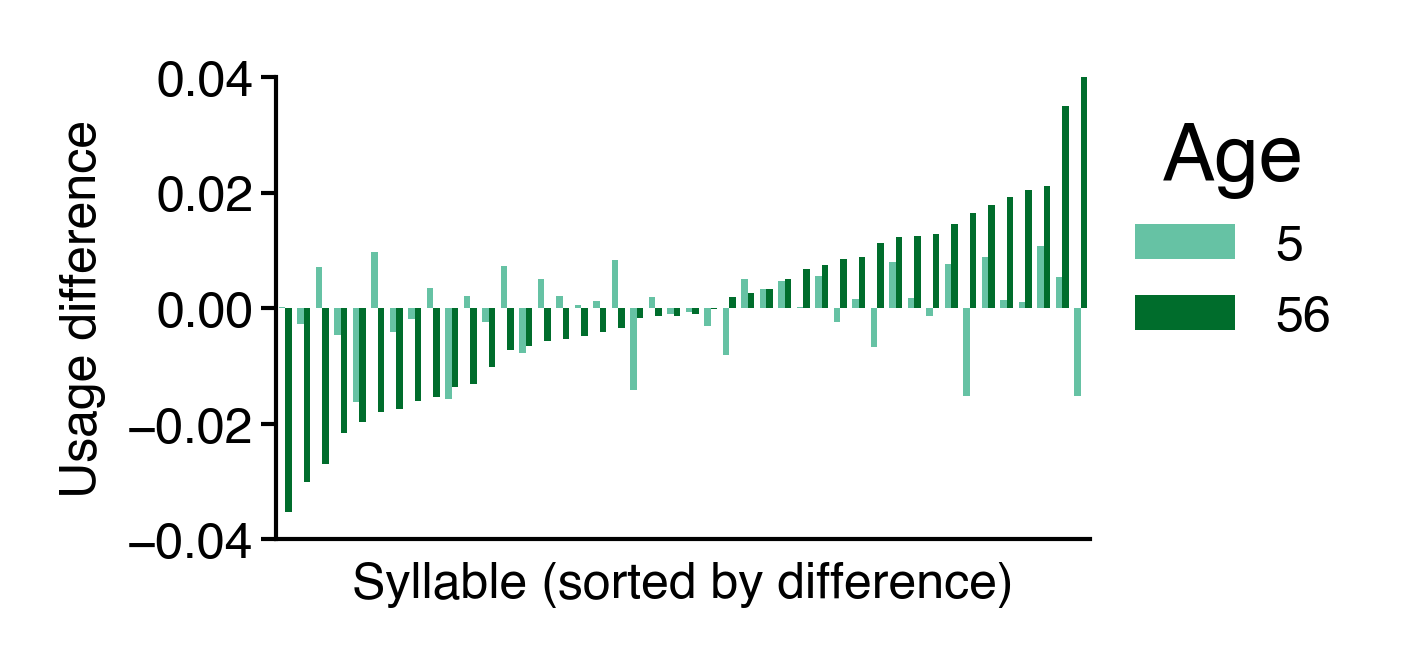

In [99]:
rs = LONGTOGENY_AGE_CMAP.resampled(6)
fig = figure(1.75, 1)
ord = syll_df.query('age == 56').sort_values(by='diff')['syllable']
ax = sns.barplot(data=syll_df, x='syllable', y='diff', hue='age', palette=rs([2, 5]).tolist(), width=0.7, saturation=1, order=ord, lw=0)
ax.set(xticks=[], ylabel="Usage difference", ylim=[-0.04, 0.04], xlabel="Syllable (sorted by difference)")
sns.despine()
legend(ax, title="Age")
saver(fig, "usage-difference-examples");

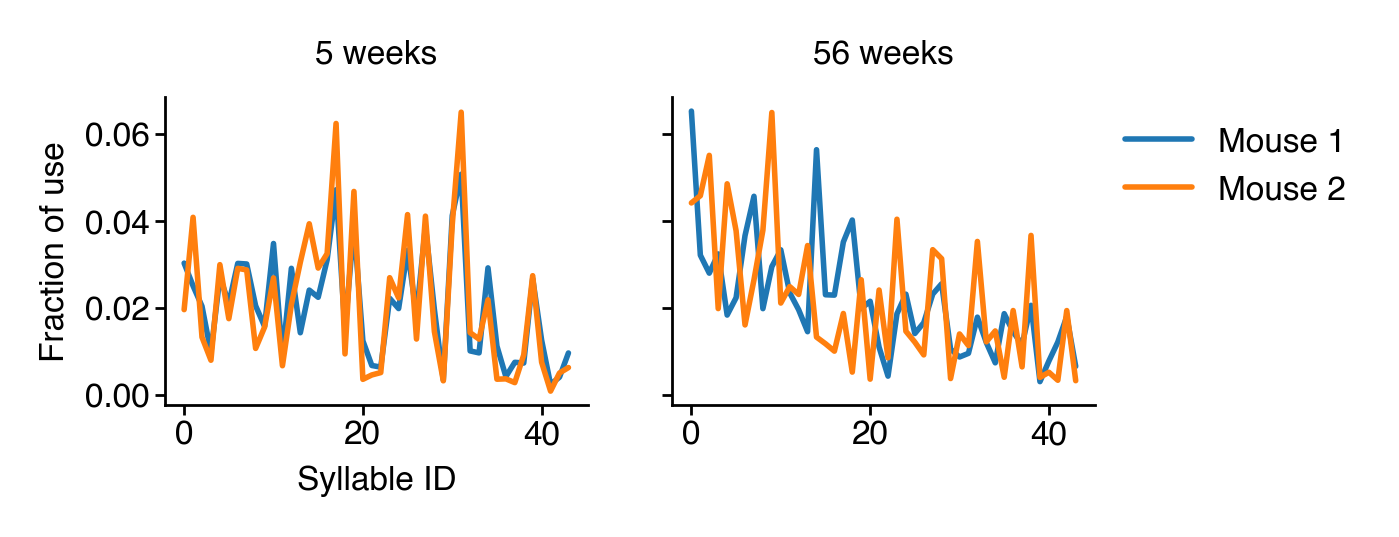

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(3, 1), sharey=True)
ax[0].plot(b1, label="Mouse 1")
ax[0].plot(b2, label="Mouse 2")
ax[1].plot(b3, label="Mouse 1")
ax[1].plot(b4, label="Mouse 2")
ax[1].set(title="56 weeks")
ax[0].set(xlabel="Syllable ID", ylabel="Fraction of use", title="5 weeks")
legend(ax[1])
sns.despine()
saver(fig, "usage-examples-two-mice");

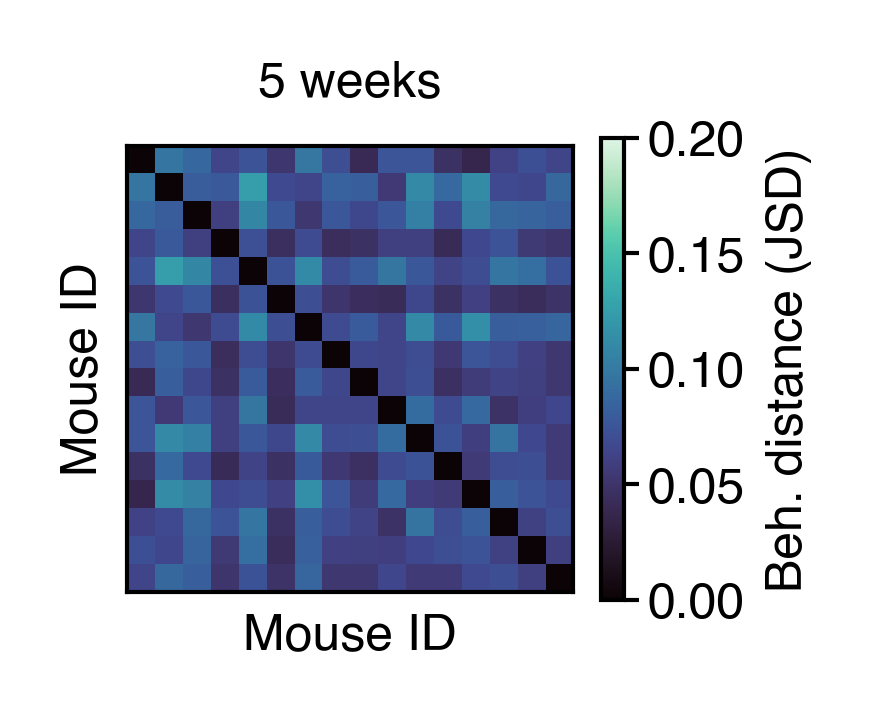

In [111]:
out = squareform(pdist(ba.loc[2]))
fig = figure(1.2, 1)
ax = fig.gca()
im = ax.imshow(out, vmax=0.2, cmap='mako')
ax.set(xticks=[], yticks=[], xlabel="Mouse ID", ylabel="Mouse ID", title="5 weeks")
fig.colorbar(im, ax=ax, label="Beh. distance (JSD)")
saver(fig, "5wk-old-beh-distance-mtx");

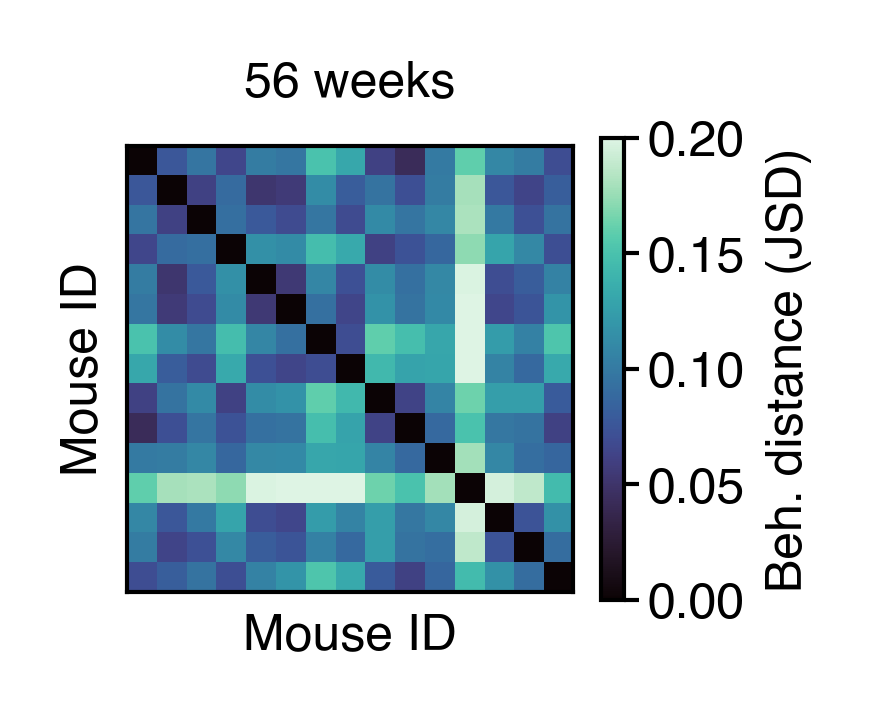

In [112]:
out = squareform(pdist(ba.loc[13]))
fig = figure(1.2, 1)
ax = fig.gca()
im = ax.imshow(out, vmax=0.2, cmap='mako')
ax.set(xticks=[], yticks=[], xlabel="Mouse ID", ylabel="Mouse ID", title="56 weeks")
fig.colorbar(im, ax=ax, label="Beh. distance (JSD)")
saver(fig, "56wk-old-beh-distance-mtx");

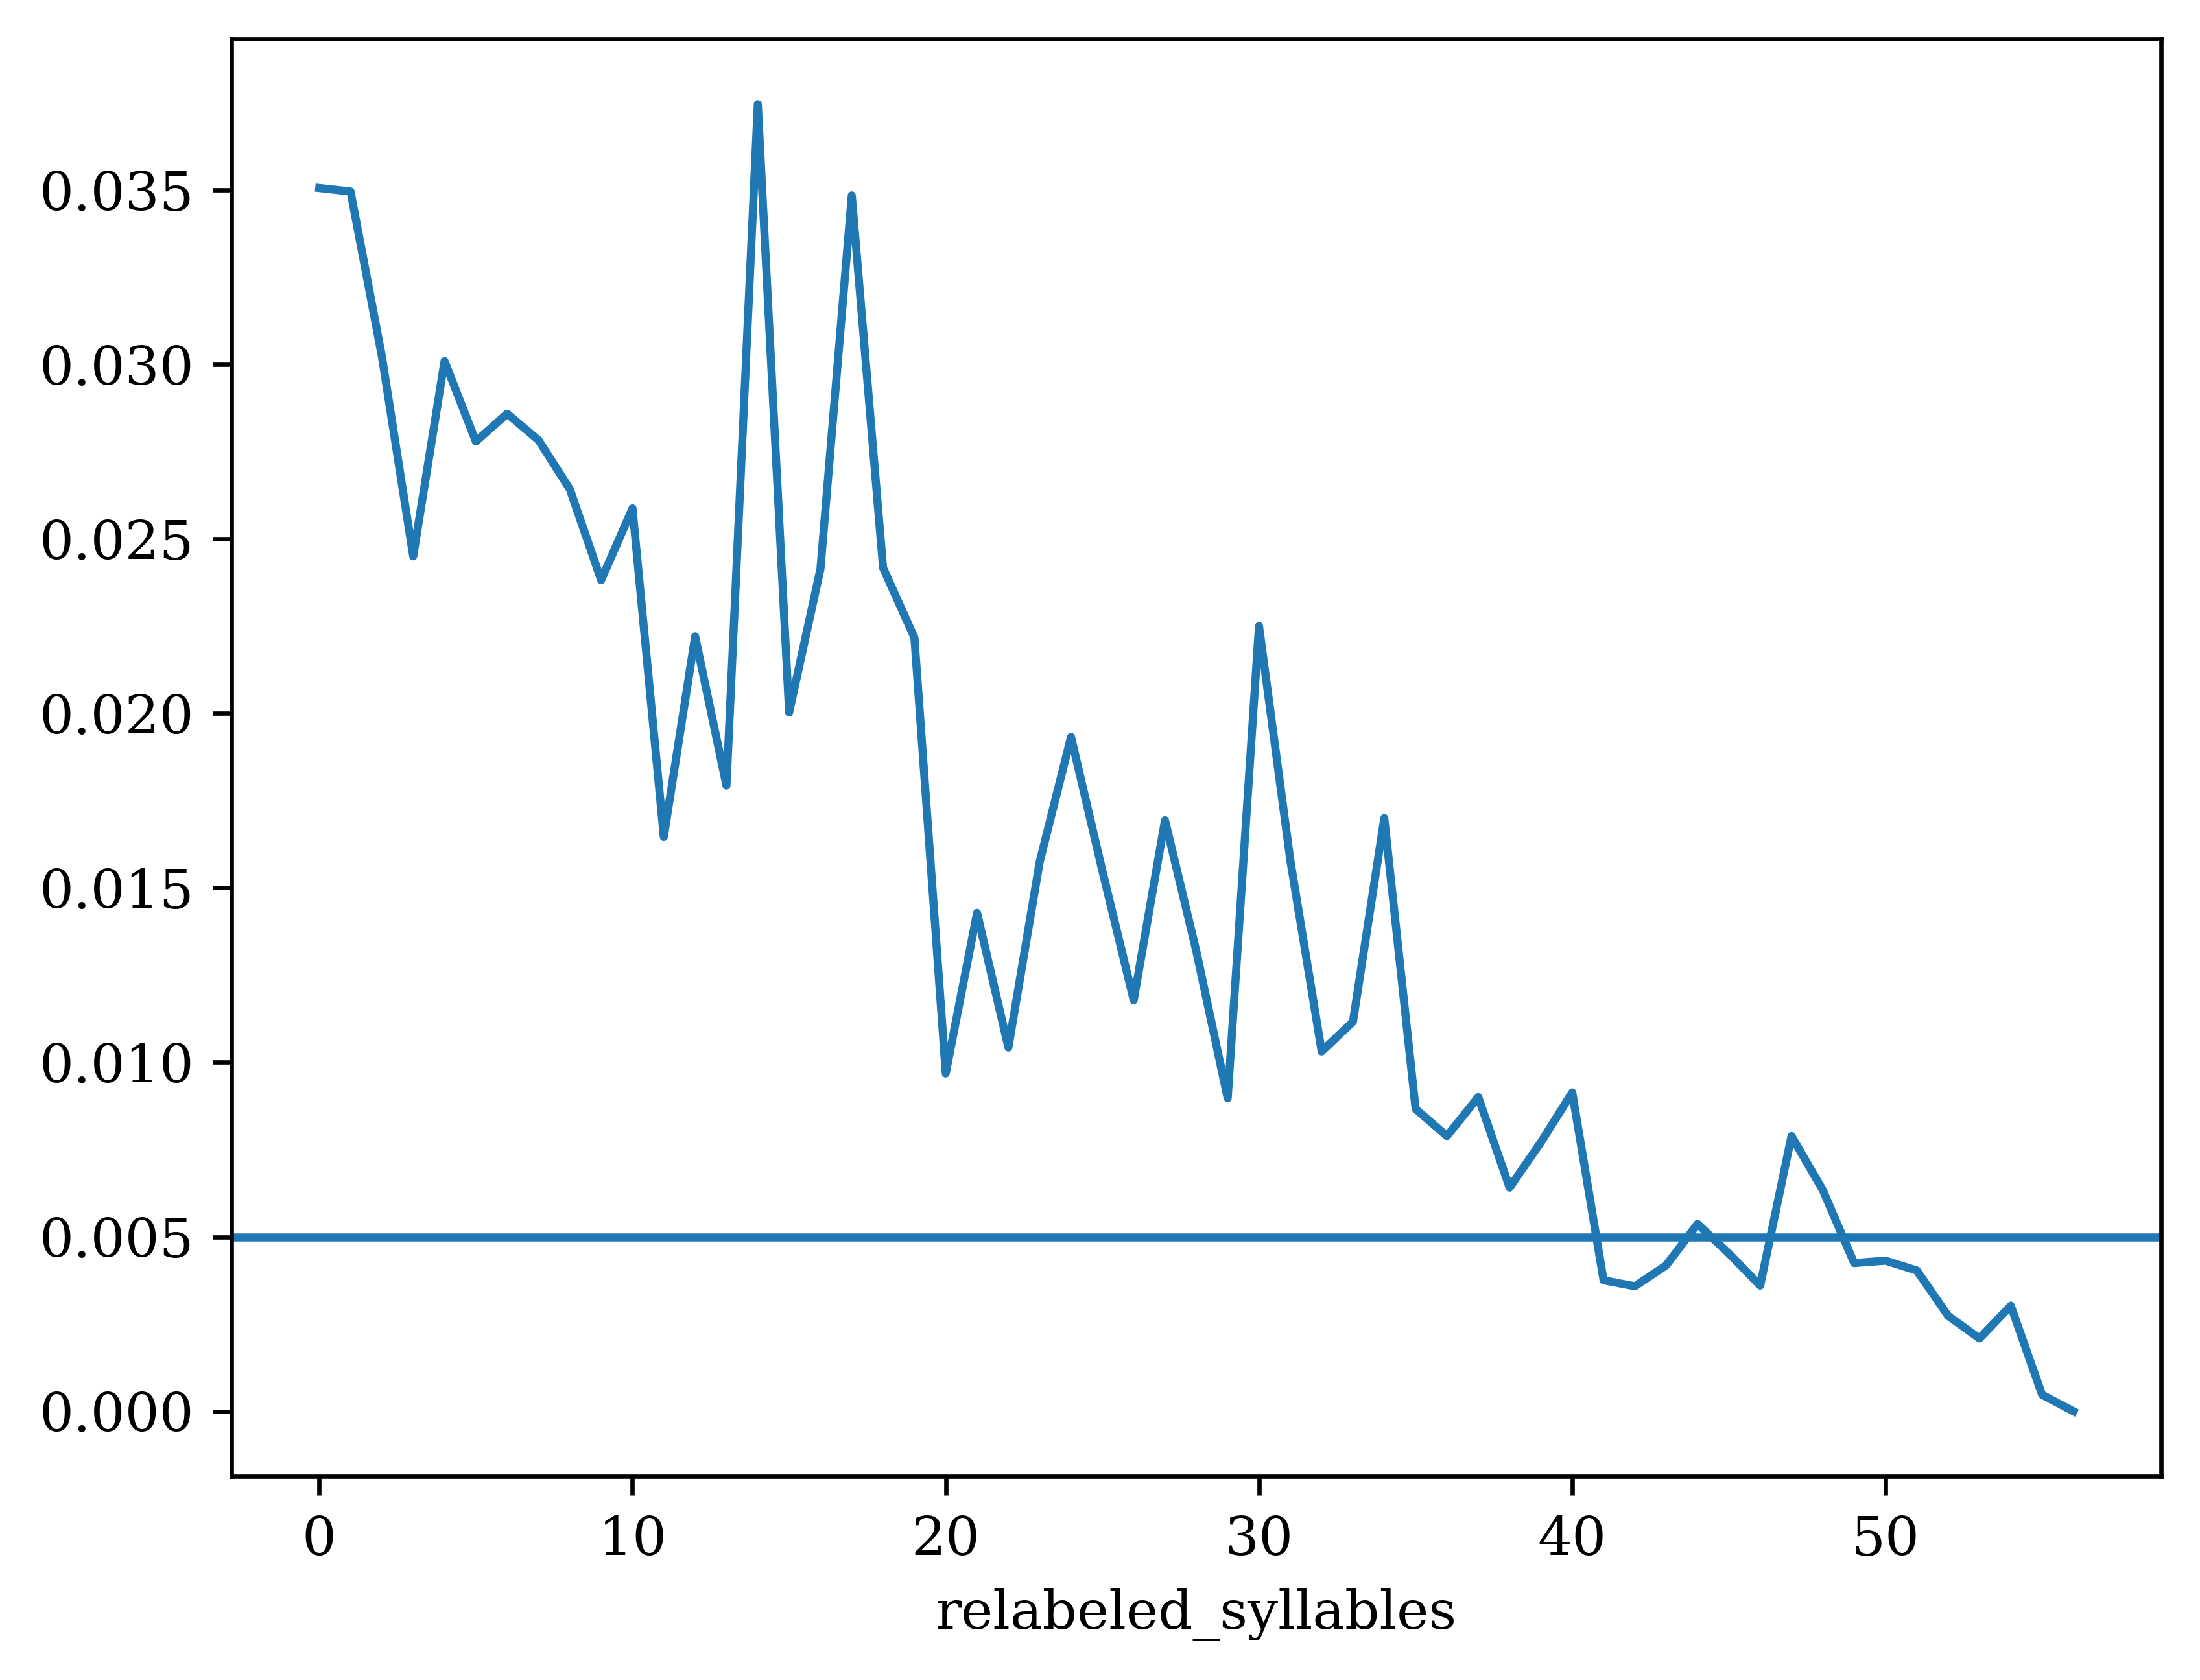

In [125]:
df.median().iloc[:-1].plot()
plt.axhline(0.005)